# Домашнее задание:

Попробуйте обучить нейронную сеть U-Net на любом другом датасете. Напишите в комментариях к уроку, какого результата вы добились от нейросети, что помогло улучшить её точность?
В качестве датасета можно взять clothing-co-parsing, я приложила файл Lesson_6_home_practice с его предобработкой

# Подготовка библиотек

In [1]:
!git clone https://github.com/bearpaw/clothing-co-parsing.git

fatal: destination path 'clothing-co-parsing' already exists and is not an empty directory.


In [2]:
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import matplotlib.pyplot as plt
import os
from scipy import io
from sklearn.model_selection import train_test_split

## Проверить устройства для кераса

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2867028960634253161
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14444920832
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5987936513926713412
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [4]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [5]:
!cat /proc/meminfo

MemTotal:       13298580 kB
MemFree:         6777784 kB
MemAvailable:   11771004 kB
Buffers:          116492 kB
Cached:          4803196 kB
SwapCached:            0 kB
Active:          2247552 kB
Inactive:        3888132 kB
Active(anon):     953904 kB
Inactive(anon):    10700 kB
Active(file):    1293648 kB
Inactive(file):  3877432 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:               768 kB
Writeback:             0 kB
AnonPages:       1215332 kB
Mapped:           776116 kB
Shmem:             11452 kB
KReclaimable:     127180 kB
Slab:             185192 kB
SReclaimable:     127180 kB
SUnreclaim:        58012 kB
KernelStack:        5360 kB
PageTables:        12304 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6649288 kB
Committed_AS:    4091932 kB
VmallocTotal:   34359738367 kB
VmallocUsed:       51404 kB
VmallocChunk:          0 kB
Percpu:          

## Функции для визуализации

In [6]:
def display(display_list):
  title = ['Input Image', 'True Mask', 'Predicted Mask']

  plt.figure(figsize=(15, 15))
  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(model, dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

## Загрузка датасета и обработка

In [7]:
DATASET_PATH = '/content/clothing-co-parsing/photos/'
MASKS_PATH = '/content/clothing-co-parsing/annotations/pixel-level/'

In [8]:
def preprocess_image(image):
     image = tf.cast(image, tf.float32)
     # scale values to [0,1]
     image = image/255.0
     # resize image
     image = tf.image.resize(image, (128,128))
     return image 
     

def preprocess_mask(mask):
    mask = tf.expand_dims(mask, axis=-1)
    mask = tf.image.resize(mask, (128,128))
    # будем использовать бинарную классификацию - фон и человек
    # для этого фон, закодированный нулем, оставим нулевым
    # все остальное будет равно единице
    mask = tf.cast(mask != 0, tf.uint8)
    return mask  

In [9]:
images = []
masks = []

for mask_filename in os.listdir(MASKS_PATH):
  image_filename = mask_filename[:-4] + '.jpg'
  image = img_to_array(load_img(DATASET_PATH + image_filename))
  images.append(preprocess_image(image))
      
  mask_file = io.loadmat(MASKS_PATH + mask_filename)
  mask = tf.convert_to_tensor(mask_file['groundtruth']) 
  masks.append(preprocess_mask(mask))

In [10]:
train_X, test_X, train_Y, test_Y = train_test_split(images, masks,\
                                                 test_size=0.2, random_state=0)
sample_image, sample_mask = train_X[0], train_Y[0]

train_X = tf.data.Dataset.from_tensor_slices(train_X)
test_X = tf.data.Dataset.from_tensor_slices(test_X)
train_Y = tf.data.Dataset.from_tensor_slices(train_Y)
test_Y = tf.data.Dataset.from_tensor_slices(test_Y)

train = tf.data.Dataset.zip((train_X, train_Y))
test = tf.data.Dataset.zip((test_X, test_Y)) 

In [11]:
# функции для аугментации 

# яркость
def brightness(img, mask):
    img = tf.image.adjust_brightness(img, 0.1)
    return img, mask

# оттенок
def hue(img, mask):
    img = tf.image.adjust_hue(img, -0.1)
    return img, mask

# отзеркаливание по горизонтали
def flip_horisontal(img, mask):
     img = tf.image.flip_left_right(img)
     mask = tf.image.flip_left_right(mask)
     return img, mask

In [12]:
# последовательно применяем аугментации
train = train.concatenate(train.map(brightness))
train = train.concatenate(train.map(hue))
train = train.concatenate(train.map(flip_horisontal))

In [13]:
len(train)

6424

In [14]:
BATCH_SIZE = 32
BUFFER_SIZE = 500
train = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train = train.prefetch(buffer_size=BUFFER_SIZE)
test = test.batch(BATCH_SIZE) 

## Модель

In [15]:
tf.random.set_seed(0)

Encoder (слои из преобученной модели MobileNetV2)

In [16]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

Decoder

In [17]:
up_stack = [
    tf.keras.layers.Conv2DTranspose(512, 3, strides=2, padding='same', 
                                    use_bias=False, activation='relu'),
    tf.keras.layers.Conv2DTranspose(256, 3, strides=2, padding='same', 
                                    use_bias=False, activation='relu'),
    tf.keras.layers.Conv2DTranspose(128, 3, strides=2, padding='same', 
                                    use_bias=False, activation='relu'),
    tf.keras.layers.Conv2DTranspose(64, 3, strides=2, padding='same', 
                                    use_bias=False, activation='relu')
]

In [18]:
def resolution_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(output_channels, 3, strides=2, 
                                         padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [19]:
OUTPUT_CHANNELS = 3

model = resolution_model(OUTPUT_CHANNELS)
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=5e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

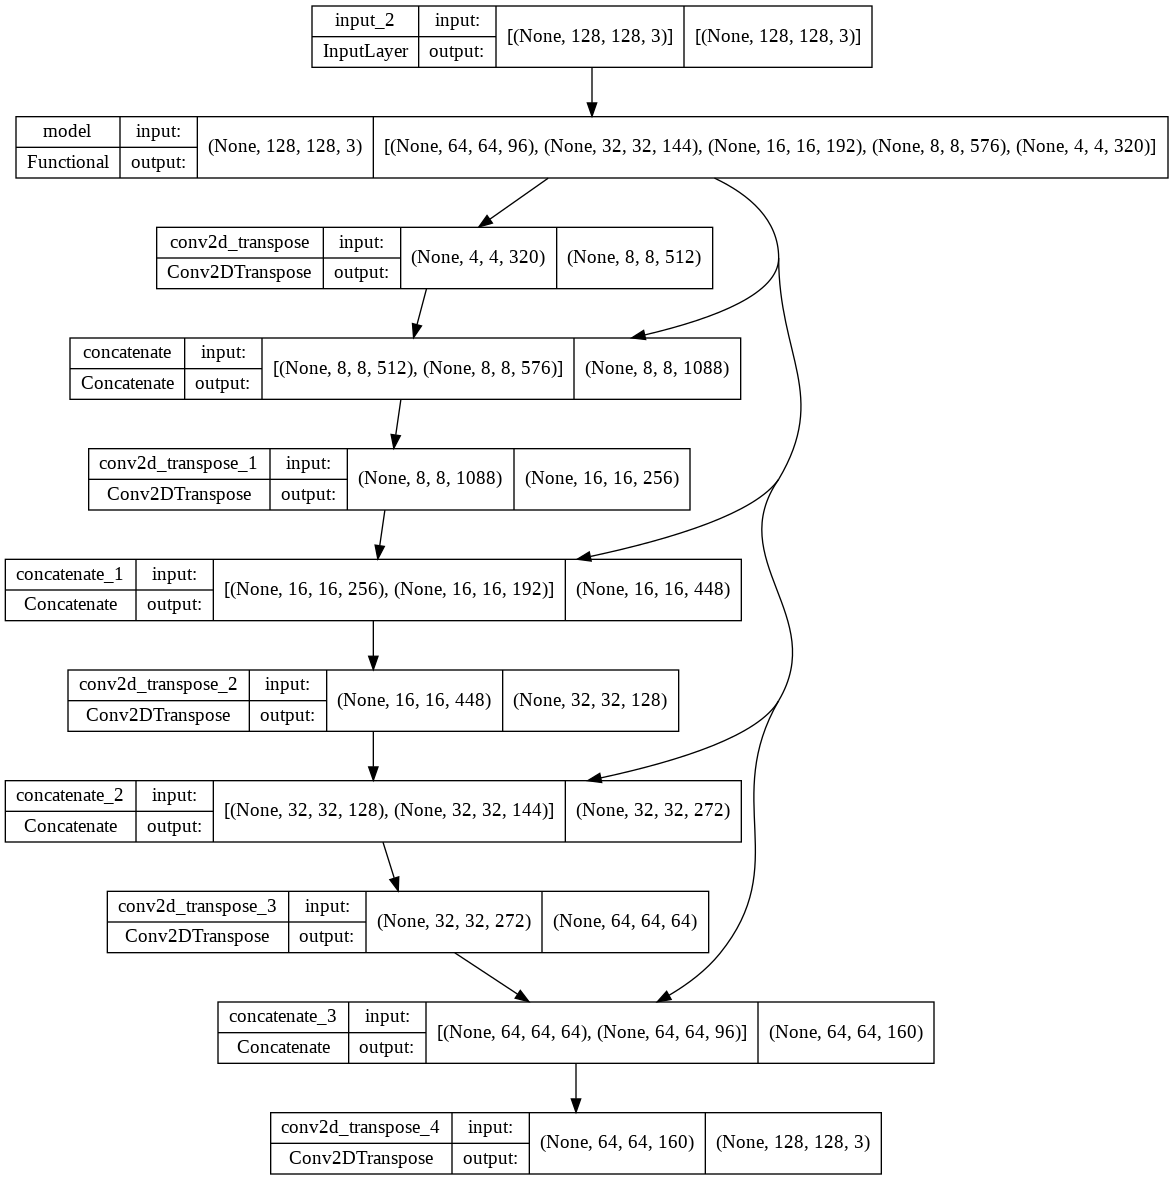

In [20]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [21]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             [(None, 64, 64, 96)  1841984     ['input_2[0][0]']                
                                , (None, 32, 32, 14                                               
                                4),                                                               
                                 (None, 16, 16, 192                                               
                                ),                                                          

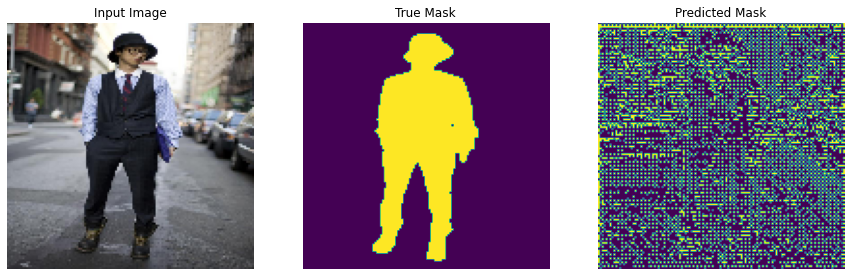

In [23]:
show_predictions(model)

## Обучение

Epoch 1/50
201/201 [==============================] - ETA: 0s - loss: 0.0462 - accuracy: 0.9817

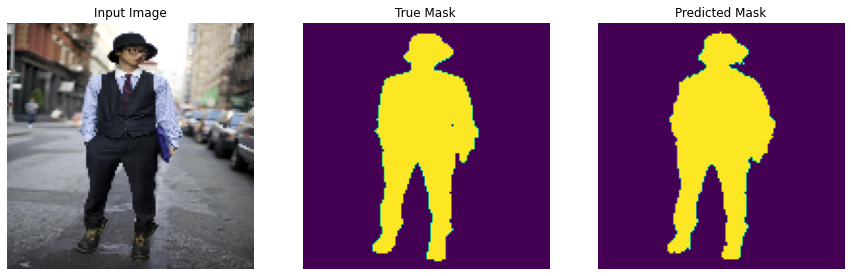


Sample Prediction after epoch 1


Epoch 1: val_loss improved from inf to 0.07484, saving model to model-lesson_6.h5
201/201 [==============================] - 13s 66ms/step - loss: 0.0462 - accuracy: 0.9817 - val_loss: 0.0748 - val_accuracy: 0.9761 - lr: 5.0000e-04
Epoch 2/50
201/201 [==============================] - ETA: 0s - loss: 0.0409 - accuracy: 0.9837

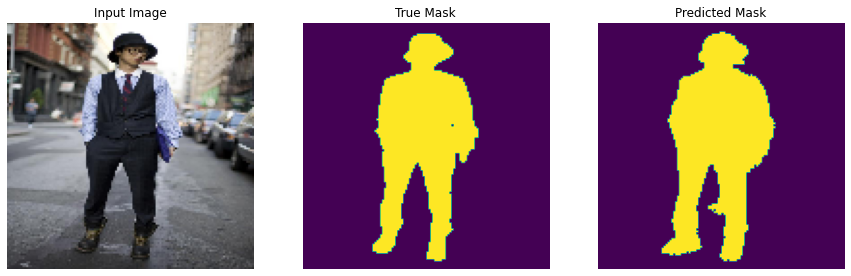


Sample Prediction after epoch 2


Epoch 2: val_loss did not improve from 0.07484
201/201 [==============================] - 13s 66ms/step - loss: 0.0409 - accuracy: 0.9837 - val_loss: 0.1130 - val_accuracy: 0.9665 - lr: 5.0000e-04
Epoch 3/50
201/201 [==============================] - ETA: 0s - loss: 0.0377 - accuracy: 0.9850

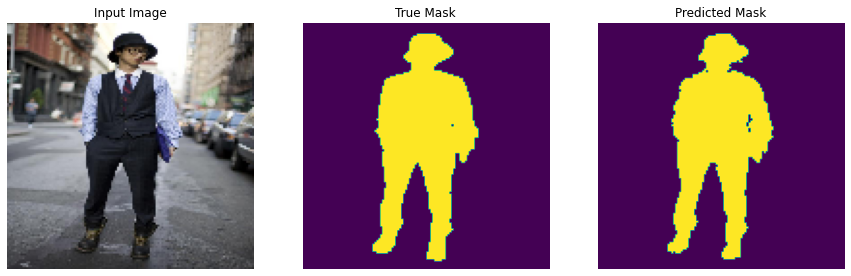


Sample Prediction after epoch 3


Epoch 3: val_loss did not improve from 0.07484
201/201 [==============================] - 14s 67ms/step - loss: 0.0377 - accuracy: 0.9850 - val_loss: 0.0749 - val_accuracy: 0.9758 - lr: 5.0000e-04
Epoch 4/50
201/201 [==============================] - ETA: 0s - loss: 0.0337 - accuracy: 0.9865

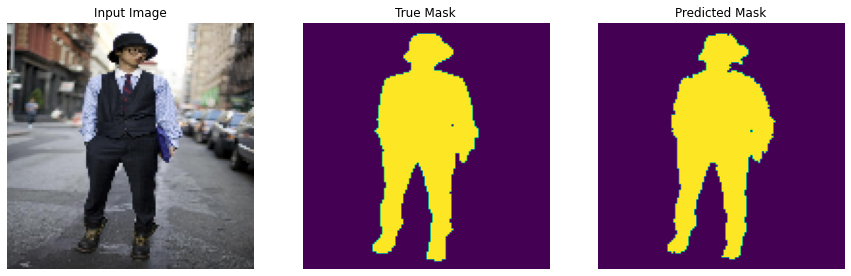


Sample Prediction after epoch 4


Epoch 4: ReduceLROnPlateau reducing learning rate to 5.0000002374872565e-05.

Epoch 4: val_loss did not improve from 0.07484
201/201 [==============================] - 13s 67ms/step - loss: 0.0337 - accuracy: 0.9865 - val_loss: 0.0889 - val_accuracy: 0.9747 - lr: 5.0000e-04
Epoch 5/50
201/201 [==============================] - ETA: 0s - loss: 0.0259 - accuracy: 0.9897

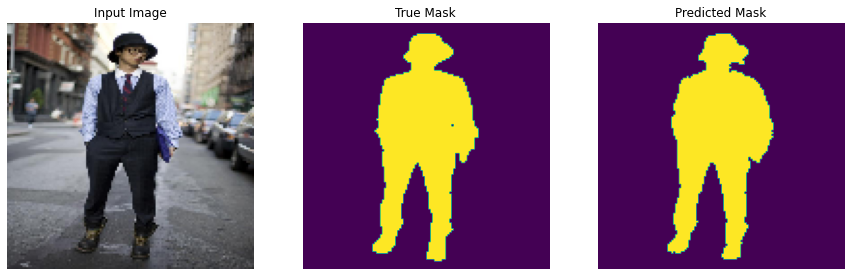


Sample Prediction after epoch 5


Epoch 5: val_loss did not improve from 0.07484
201/201 [==============================] - 14s 67ms/step - loss: 0.0259 - accuracy: 0.9897 - val_loss: 0.0869 - val_accuracy: 0.9769 - lr: 5.0000e-05
Epoch 6/50
201/201 [==============================] - ETA: 0s - loss: 0.0244 - accuracy: 0.9902

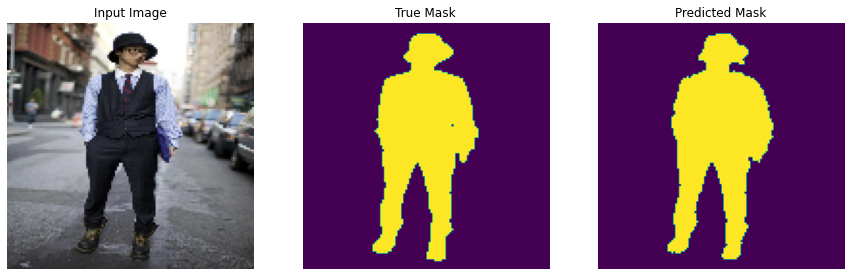


Sample Prediction after epoch 6


Epoch 6: val_loss did not improve from 0.07484
201/201 [==============================] - 13s 65ms/step - loss: 0.0244 - accuracy: 0.9902 - val_loss: 0.0892 - val_accuracy: 0.9769 - lr: 5.0000e-05
Epoch 7/50
201/201 [==============================] - ETA: 0s - loss: 0.0233 - accuracy: 0.9907

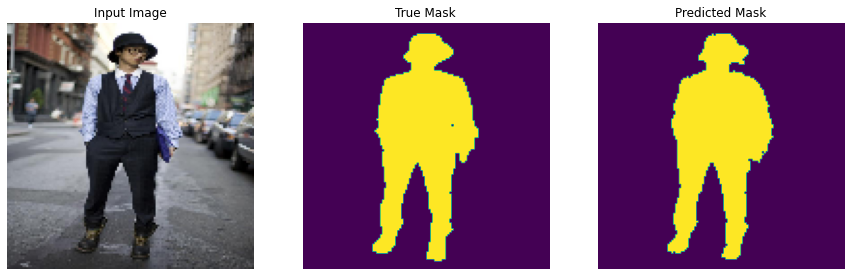


Sample Prediction after epoch 7


Epoch 7: ReduceLROnPlateau reducing learning rate to 5.000000237487257e-06.

Epoch 7: val_loss did not improve from 0.07484
201/201 [==============================] - 14s 67ms/step - loss: 0.0233 - accuracy: 0.9907 - val_loss: 0.0919 - val_accuracy: 0.9767 - lr: 5.0000e-05
Epoch 8/50
201/201 [==============================] - ETA: 0s - loss: 0.0229 - accuracy: 0.9908

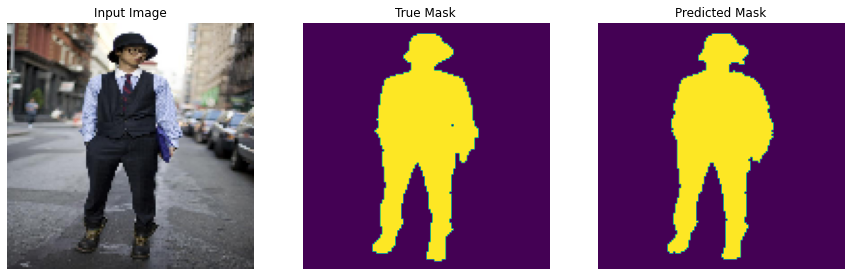


Sample Prediction after epoch 8


Epoch 8: val_loss did not improve from 0.07484
201/201 [==============================] - 14s 68ms/step - loss: 0.0229 - accuracy: 0.9908 - val_loss: 0.0917 - val_accuracy: 0.9769 - lr: 5.0000e-06
Epoch 9/50
201/201 [==============================] - ETA: 0s - loss: 0.0227 - accuracy: 0.9909

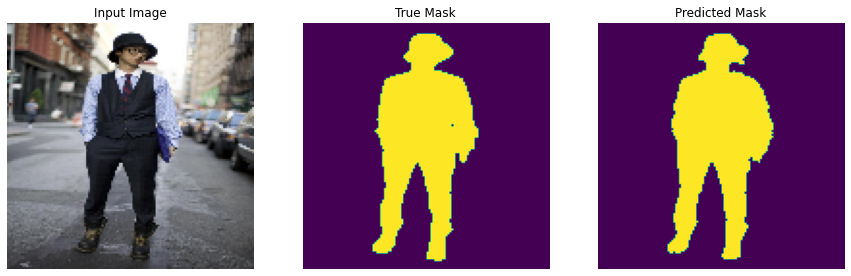


Sample Prediction after epoch 9


Epoch 9: val_loss did not improve from 0.07484
201/201 [==============================] - 13s 67ms/step - loss: 0.0227 - accuracy: 0.9909 - val_loss: 0.0915 - val_accuracy: 0.9769 - lr: 5.0000e-06
Epoch 10/50
201/201 [==============================] - ETA: 0s - loss: 0.0225 - accuracy: 0.9910

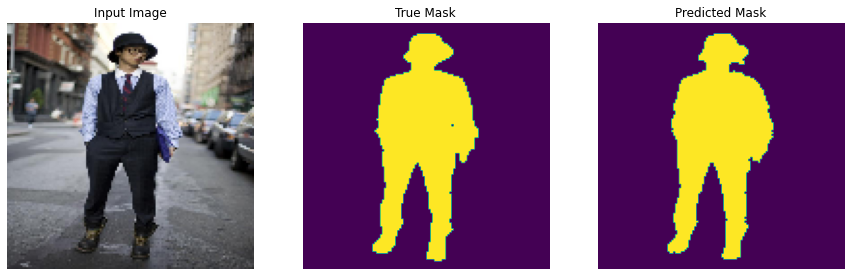


Sample Prediction after epoch 10


Epoch 10: ReduceLROnPlateau reducing learning rate to 5.000000328436726e-07.

Epoch 10: val_loss did not improve from 0.07484
201/201 [==============================] - 13s 67ms/step - loss: 0.0225 - accuracy: 0.9910 - val_loss: 0.0915 - val_accuracy: 0.9769 - lr: 5.0000e-06
Epoch 11/50
201/201 [==============================] - ETA: 0s - loss: 0.0226 - accuracy: 0.9910

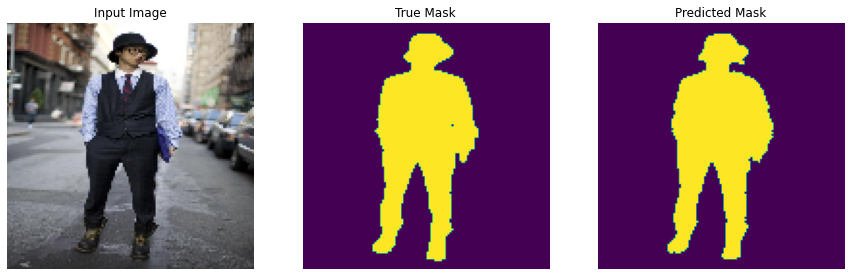


Sample Prediction after epoch 11


Epoch 11: val_loss did not improve from 0.07484
201/201 [==============================] - 13s 67ms/step - loss: 0.0226 - accuracy: 0.9910 - val_loss: 0.0913 - val_accuracy: 0.9770 - lr: 5.0000e-07
Epoch 11: early stopping


In [29]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    show_predictions(model)
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))


EPOCHS = 50

model_history = model.fit(train, epochs=EPOCHS,
                          batch_size=BATCH_SIZE,
                          validation_data=test,
                          callbacks=[DisplayCallback(),
                                     EarlyStopping(patience=10, verbose=1),
                                     ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.000000001, verbose=1),
                                     ModelCheckpoint('model-lesson_6.h5', verbose=1, save_best_only=True, save_weights_only=True)])
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

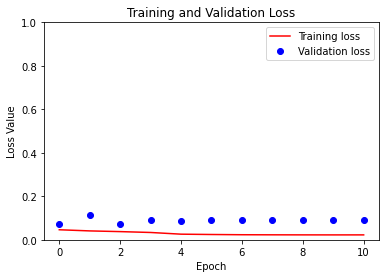

In [30]:
epochs = range(11)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

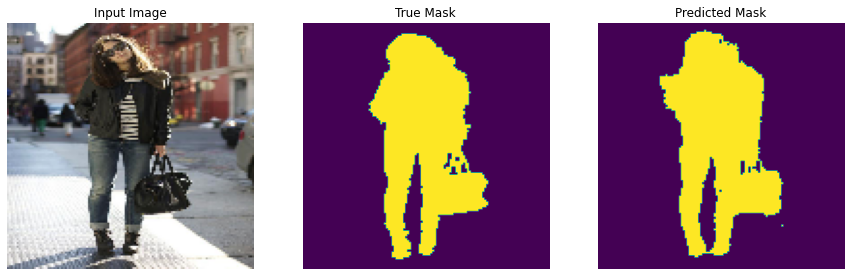

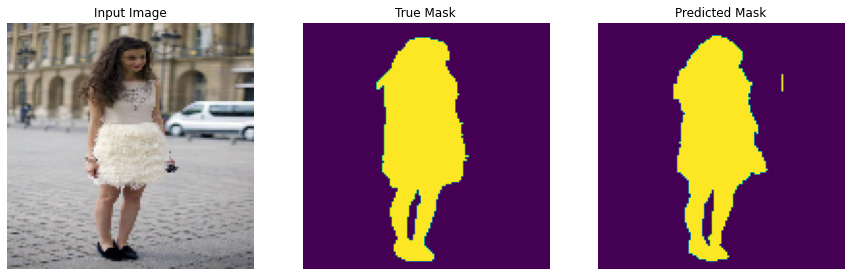

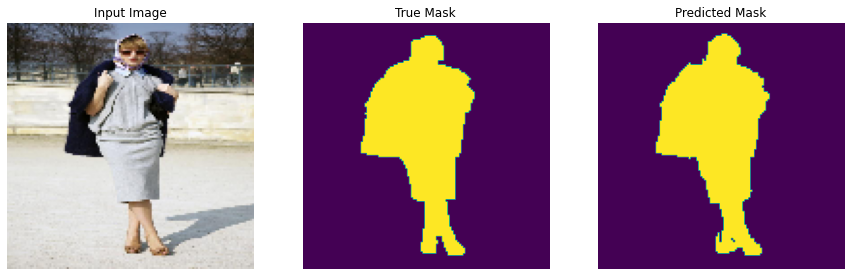

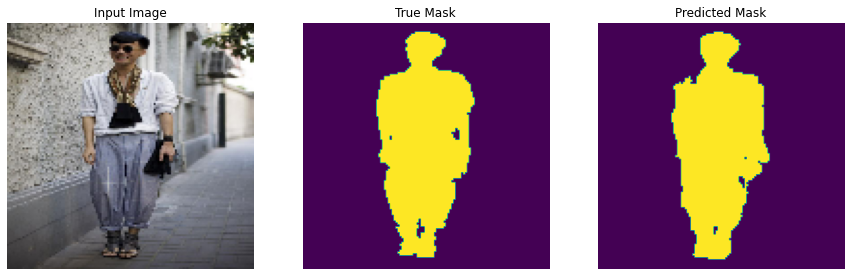

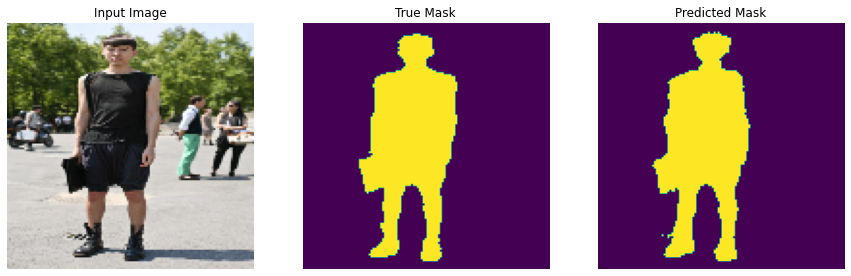

In [33]:
show_predictions(model, test, 5)

### Вывод:

- Прослеживается сильное переобучение модели;
- Наилучший результат достигнут при использовании оптимизатора RMSprop;